# **Quantum Longest Common Substring**

Con il seguente elaborato, si affronta una soluzione ibrida classico-quantistica per la risoluzione del problema **Longest Common Substring**.

> Cantone, Domenico & Faro, Simone & Pavone, Arianna & Viola, Caterina. (2023). Longest Common Substring and Longest Palindromic Substring in $\tilde{\mathcal{O}}(\sqrt{n})$ Time. 10.48550/arXiv.2309.01250. 

## **Problema Longest Common Substring**

Il problema Longest Common Substring è un **problema di ottimizzazione** definito nel seguente modo:

> Date due stringhe $X = \{x_1, x_2, \dots, x_n\}$ e $Y = \{y_1, y_2, \dots, y_m\}$, trovare $S = \{s_1, s_2, \dots, s_k\}$ tale che $S$ sia sottostringa sia di $X$ che di $Y$, e massimizzando la lunghezza $k$. 

È un problema tipico del text processing, cui soluzioni trovano applicazioni nell'ambito della deduplicazione dei dati, negli algoritmi anti-plagio e nella bioinformatica (assieme al Longest Common Subsequence).

## **Quantum-LCS Algorithm**

L'algoritmo che si propone, è una soluzione ibrida classico-quantistica, che si compone di un algoritmo iterativo classico, e uno step di verifica quantistico.

```
QUANTUM-LCS(x,y,n):                    
    l = 0;                             
    r = n;                             
    while l < r do                     
        d = floor((l+r)/2)             
        if QUANTUM-TEST(x, y, d) then  
            l = d                      
        else                           
            r = d - 1                  
                                       
    return l                           
```

## **Algoritmo classico**

Tratteremo temporaneamente $\text{QUANTUM-TEST}(X, Y, d)$ come una black-box, ignorandone il funzionamento, ma solo il comportamento. Questa funzione ritorna `True` se e solo se 
$$\exists S \text{ sottostringa di } X \text{ e } Y \text{ di dimensione } d$$


Noto questo, l'algoritmo $\text{QUANTUM-LCS}(X,Y,n)$ si basa su una ricerca binaria del valore di $k$, verificando ad ogni step usando $\text{QUANTUM-TEST}(X,Y,d)$ come verifica. In altre parole:


> 1. Pongo $l = 0$ ed $r = n$. Questi coincidono col più ampio range di valori che la dimensione della LCS può assumere, ossia $0 \leq |S| \leq n$.
> 2. Stimo che la LCS tra $X$ e $Y$ sia di dimensione $d = \lfloor (l + r)/2\rfloor$.
> 3. Se esiste una sottostringa comune a $X$ e a $Y$ di dimensione $d$, pongo $l = d$, altrimenti pongo $r = d - 1$.
> 4. Se $l = r$, $l$ è la lunghezza della LCS ad $X$ e $Y$, altrimenti torno allo step $2$. 

Noto questo, è banale dire che la complessità della funzione, sarà:

$$
\mathcal{O}(\log n) \cdot (\text{Complessità di QUANTUM-TEST})
$$

## **Test quantistico**

Affrontiamo adesso l'analisi della componente quantistica dell'algoritmo. Abbiamo già detto che vogliamo che $\text{QUANTUM-TEST}(X,Y,d)$ torni `True` se e solo se esiste una sottostringa di dimensione $d$ condivisa tra $X$ e $Y$.

### **Prerequisiti di computazione quantistica**

Riassumiamo i prerequisiti di computazione quantistica (non triviali) richiesti per la comprensione della funzione $\text{QUANTUM-TEST}(X,Y,d)$.

- [Oracoli booleani](../q-miscellaneous/q-oracles/boolean-oracles.ipynb) - gate che implementano funzioni del tipo $f: \{0,1\}^n \to \{0,1\}$;
- [Phase kickback](../q-miscellaneous/q-oracles/phase-kickback.ipynb) - conseguenza dell'applicazione di operazioni controllate su qubit in sovrapposizione;
- [Oracoli di fase](../q-miscellaneous/q-oracles/phase-oracles.ipynb) - i quali uniscono le intuizioni degli oracoli booleani col phase kickback;
- Operatore di rotazione arbitraria;
- [Algoritmo di Grover](../Grover-algorithm/grover.ipynb) - per amplificare la probabilità di ottenere stati che soddisfano le condizioni di un oracolo di fase.

### **Idea dietro il test quantistico**

Come tutti i problemi risolti tramite l'algoritmo di Grover, vogliamo costruire degli oracoli di fase $P_f$ per invertire la fase delle soluzioni che cerchiamo. Lo step di diffusione, farà invece da ponte tra la verifica di una soluzione e la sua costruzione effettiva.

Ricordiamo che col nostro $\text{QUANTUM-TEST}$ vogliamo porre la seguente domanda:

$$
\text{Esiste una sottostringa di dimensione $d$ comune a $X$ e $Y$?}
$$
Introduciamo quindi gli oracoli necessari per il test.

- $\text{SFC}$: Shared Fix Substring Check.
- $\text{FPM}$: Fixed Prefix Matching

costruiti entrambi come variazioni dell'operatore $\text{Fixed Substring Matching}$, o $\text{FSM}$, nel quale è possibile specificare la posizione di partenza della sottostringa (tramite $|D[-1]\rangle$), e la sua dimensione (tramite $|d\rangle$).

## **Operatore FSM**

Costruito usando i seguenti operatori ausiliari:

- $\text{MATCH}$
- $\text{EXT}_i$
- $\text{ROT}$ e operatori di rotazione $\text{R}_i$
- $\text{C-AND}$
- $\text{C-COPY}$
- $\text{OR}$

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from BoredQiskit.FastUtilsGate import int_to_bin
import numpy as np

### **Operatore di match**

Confronta due sequenze binarie di lunghezza $n$, scrivendo su delle linee d'output di dimensione $n$. Ha profondità costante $\mathcal{O}(1)$. Viene utilizzato per costruire il vettore $\lambda^0$.

$$
\lambda^{0}[j] = (x_j \land y_j) \lor (\neg x_j \land \neg y_j).
$$

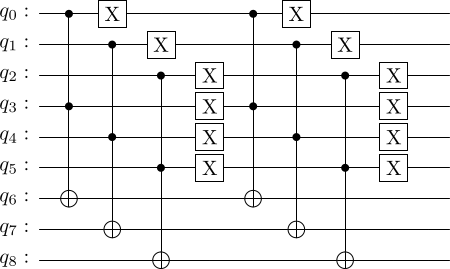

In [3]:
def match_operator(n: int):
    '''
    page 12 of the paper
    '''
    qx = QuantumRegister(n, 'x')
    qy = QuantumRegister(n, 'y')
    qout = QuantumRegister(n, 'o')
    qc = QuantumCircuit(qx, qy, qout)
    
    for i in range(n):
        qc.ccx(qx[i], qy[i], qout[i])

    qc.x(qx)
    qc.x(qy)

    for i in range(n):
        qc.ccx(qx[i], qy[i], qout[i])
    
    qc.x(qx)
    qc.x(qy)
    
    return qc.to_gate(label='MATCH')

qc = QuantumCircuit(9)
qc = qc.compose(match_operator(3)).decompose()
qc.draw('latex')

### **Operatore di estensione**

Costruisce il vettore di *matching substring* $\lambda^i$ partendo dal vettore $\lambda^{i-1}$. Ogni vettore $\lambda^i$ contiene $1$ nelle posizioni che coincidono con l'inizio di una sottostringa di lunghezza $2^i$.

Ogni vettore $\lambda$ è definito come

$$
\lambda^{i}[j] = \lambda^{i-1}[j] \land \lambda^{i-1}[j + 2^{i-1}]
$$

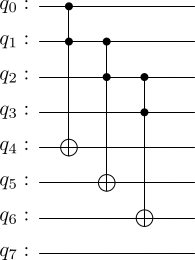

In [ ]:
def extension_operator(n: int, i: int):
    '''
    page 12 of the paper
    '''
    shift = 2 ** (i - 1)

    qin = QuantumRegister(n, 'in')    
    qout = QuantumRegister(n, 'out')
    qc = QuantumCircuit(qin, qout)

    for j in range(n - shift):
        qc.ccx(qin[j], qin[j + shift], qout[j])

    return qc.to_gate(label=f'EXT_{i}')

qc = QuantumCircuit(8)
qc = qc.compose(extension_operator(4,1)).decompose()
qc.draw('latex')

### **Operatori di rotazione**

Fondamentali nel contesto degli algoritmi di ricerca su stringhe basati su Grover.

In [8]:
def quantum_rotation(n: int, s: int):
    '''
    Returns a `.Gate` that implements a rotation
    of `s` positions on `n` qubits lines.
    
    Only works correctly if `s` is a power of 2. Every other
    rotation can be obtained by combination of the power of 2 rotations; so

    DONT USE THIS !!!
    '''
    qr = QuantumRegister(n, 'q')
    qc = QuantumCircuit(qr)
    
    for i in range(1, int(np.ceil(n/2))):
        qc.swap(qr[i], qr[n-i])
    
    for j in range(1, int(np.ceil(n/2))):
        qc.swap(qr[int(np.ceil(s/2))-j], qr[int(np.floor(s/2))+j])

    return qc.to_gate(label='R_'+str(s)+' ')


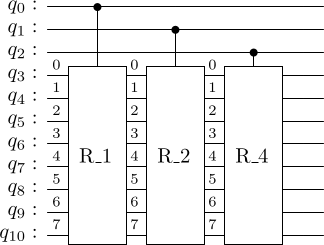

In [ ]:
def quantum_parametric_rotation(n: int):
    '''
    Returns an arbitrary rotation `.Gate` on `n` qubits lines.

    page 9 of the paper
    '''
    l = int(np.ceil(np.log2(n)))

    jr = QuantumRegister(l, 'j')
    qr = QuantumRegister(n, 'q')

    qc = QuantumCircuit(jr, qr)
    for i in range(l):
        
        qc = qc.compose(quantum_rotation(n, 2**i).control(1), [i,*qr])
    return qc

qc = QuantumCircuit(11)
qc = qc.compose(quantum_parametric_rotation(8))
qc.draw('latex')


### **Operatore di "copia"**

Con "copia", ci riferiamo alla copia di stati base $|0\rangle$ e $|1\rangle$, nel totale rispetto (a malincuore?) del teorema di non-clonazione.